In [5]:

from Packages.MassLynxRawReader import MassLynxRawReader
from Packages.MassLynxRawScanReader import MassLynxRawScanReader
from Packages.MassLynxRawInfoReader import MassLynxRawInfoReader
from Packages.MassLynxRawChromatogramReader import MassLynxRawChromatogramReader
from Packages.MassLynxRawAnalogReader import MassLynxRawAnalogReader
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.signal import normalize
from hplc.quant import Chromatogram
import numpy as np
import plotly.express as px
import os
import glob
from pathlib import Path
import csv
import json

#MSDirectory = Path('F:\\Ram Data 210824')
MSJSonpredict = r'C:\Users\sriramv\UoL Leverhulme Dropbox\Sriram Vijayakrishnan\RoboticRxnOpt Python\waters-lcms-raw-extractor\MSpeak.json'

MSDirectory = Path('F:\\Photochem')
rawpath1 = r'C:\Users\Administrator\Desktop\Ram Processing\waters-lcms-raw-extractor-main\test5.raw'


In [6]:
class Peak:

    def __init__ (self, PeakRT, PeakArea, PeakHeight):

        self.PeakRT = PeakRT
        self.PeakArea = PeakArea
        self.PeakHeight = PeakHeight
    
    def GetPeakRT (self):
        return self.PeakRT
    
    def GetPeakArea (self):
        return self.PeakArea
    
    def GetPeakHeight (self):
        return self.PeakHeight


In [20]:
class MSFile:

    def __init__ (self, rawpath):
        self.inforeader = MassLynxRawInfoReader(rawpath)
        self.chromreader = MassLynxRawChromatogramReader(rawpath)
        self.scanreader = MassLynxRawScanReader(rawpath)
        self.analogreader = MassLynxRawAnalogReader(rawpath)
        self.TICpeaks = []
        self.MSScanPeaks = []
        self.analogpeaks = []
        self.analogpeakwidths = []
        self.analogpeakfraction = []
        self.rtmax = 1
        self.MSScanmax = 1

    def NumFunctions(self):
        return self.inforeader.GetNumberofFunctions()
    
    def ChannelCount (self):
        return self.inforeader.GetChannelCount()
    
    def NumScans(self, FuncNo):
        return self.inforeader.GetScansInFunction(FuncNo)

    def GetMSScanPeaks (self):
        return self.MSScanPeaks
    
    def PlotTIC(self, FuncNo):
        timelist = []
        intlist = []
        TICdf = pd.DataFrame()
        timelist, intlist = self.chromreader.ReadTIC(FuncNo)
        timepd = pd.DataFrame(timelist, columns = ["X"])
        intensitypd = pd.DataFrame(intlist, columns = ["Y"])
        TICdf = pd.concat([timepd, intensitypd], axis=1)
        TICdf.Y = ((TICdf.Y - TICdf.Y.min()) / (TICdf.Y.max() - TICdf.Y.min())) 
        fig = px.line(TICdf, x='X', y='Y')
        fig.show()
        return TICdf

    def TICPeaks(self, FuncNo):
        timelist = []
        intlist = []
        TICdf = pd.DataFrame()
        timelist, intlist = self.chromreader.ReadTIC(FuncNo)
        timepd = pd.DataFrame(timelist, columns = ["X"])
        intensitypd = pd.DataFrame(intlist, columns = ["Y"])
        TICdf = pd.concat([timepd, intensitypd], axis=1)
        TICdf.Y = ((TICdf.Y - TICdf.Y.min()) / (TICdf.Y.max() - TICdf.Y.min())) 
        peaks, info = find_peaks(x = TICdf.Y, height = 0.2, distance = 50)
        TICdf.plot(x= 'X', y = 'Y')
        plt.plot(TICdf.iloc[peaks].X, TICdf.iloc[peaks].Y, "X")
        plt.show()

        #fig = px.line(TICdf, x='X', y='Y')
        #fig.add_scatter(x=TICdf.iloc[peaks].X, y=TICdf.iloc[peaks].Y, name = "Peaks", mode = 'markers')
        #fig.show()
        self.TICpeaks = peaks

        TICdf = TICdf.rename(columns={"X" : "time", "Y" : "signal"})
        
        return TICdf
        
        
    
    def PeaksMS(self, FuncNo):
        

        for W in self.TICpeaks:
            timelist = []
            intlist = []
            timelist, intlist = self.scanreader.ReadScan(FuncNo, W)
            MSdf = pd.DataFrame()
            timepd = pd.DataFrame(timelist, columns = ["X"])
            intensitypd = pd.DataFrame(intlist, columns = ["Y"])
            MSdf = pd.concat([timepd, intensitypd], axis=1)
            MSdf.Y = ((MSdf.Y - MSdf.Y.min()) / (MSdf.Y.max() - MSdf.Y.min()))
            peaks, info = find_peaks(x = MSdf.Y, height = 0.3, distance=30)
            print(MSdf.iloc[peaks])
            MSdf.plot(x='X', y= 'Y', rot=0)
            plt.plot(MSdf.iloc[peaks].X, MSdf.iloc[peaks].Y, "X")
            plt.show()

            self.MSScanPeaks = MSdf.iloc[peaks].X.to_numpy()
            #print(self.MSScanPeaks)



            #fig = px.line(MSdf, x='X', y='Y')
            #fig.add_scatter(x=MSdf.iloc[peaks].X, y=MSdf.iloc[peaks].Y, name = "Peaks", mode = 'markers',) 
            #fig.show()

    def FileInfo(self):

        numfunc = self.inforeader.GetNumberofFunctions()
        print("Number of Functions: " + str(self.inforeader.GetNumberofFunctions()))
        
        for x in range(0, numfunc):
            print("Function Number: " + str(x) + ". Function Type: " + str(self.inforeader.GetIonModeString(self.inforeader.GetIonMode(x))))
            print("Number Scans in Function: " + str(x) + str(self.inforeader.GetScansInFunction(x)))
    

    def Analog(self, FuncNo):

        timelist = []
        intlist = []
        ANdf = pd.DataFrame()
        timelist, intlist = self.analogreader.ReadChannel(FuncNo)
        timepd = pd.DataFrame(timelist, columns = ["X"])
        intensitypd = pd.DataFrame(intlist, columns = ["Y"])
        ANdf = pd.concat([timepd, intensitypd], axis=1)
        ANdf.Y = (ANdf.Y/ANdf.Y.max())

        self.rtmax = ANdf.X.max()

        peaks, info = find_peaks(x = ANdf.Y, height = 0.25, distance = 50)
        peakwidth, peakheights, peakLPS, peakRPS = peak_widths(ANdf.Y, peaks, rel_height = 0.97)

        ANdf.plot(x= 'X', y = 'Y')
        plt.plot(ANdf.iloc[peaks].X, ANdf.iloc[peaks].Y, "X")


        
        plt.hlines(peakheights, ANdf.iloc[np.rint(peakLPS)].X, ANdf.iloc[np.rint(peakRPS)].X, color = "C3")

        
        
        FileAnalogPeaks = {}

        PeakCounter = 1 

        PeakAreaSum = 0

        for w, x, y, z in zip(peaks, peakheights, peakLPS, peakRPS):
            
           

           plt.fill_between(ANdf.iloc[round(y):round(z)].X, x, ANdf.iloc[round(y):round(z)].Y)

           peakarea = np.trapz(ANdf.iloc[round(y):round(z)].Y - x, dx = 1)

           FileAnalogPeaks[PeakCounter] = Peak(ANdf.iloc[w].X, peakarea, ANdf.iloc[w].Y)

           print('Peak Number:', PeakCounter, 'Peak RT: ', FileAnalogPeaks[PeakCounter].GetPeakRT(), 'Peak Area:', FileAnalogPeaks[PeakCounter].GetPeakArea(), 'Peak Height: ', FileAnalogPeaks[PeakCounter].GetPeakHeight())

            
           PeakCounter = PeakCounter + 1
           PeakAreaSum = PeakAreaSum + peakarea

        print('-------------------------------------------------')

        for FilePeak in FileAnalogPeaks:

            print('Peak Number: ', FilePeak, 'LC Area Percentage: ', round(((FileAnalogPeaks[FilePeak].GetPeakArea() / PeakAreaSum)*100),2), '%') 

    
        
        plt.show()
        self.analogpeaks = ANdf.iloc[peaks].X.to_numpy()
        self.analogpeakfraction = self.analogpeaks/self.rtmax

        ANdf = ANdf.rename(columns={"X" : "time", "Y" : "signal"})


        return ANdf







def MSProcessFolder(Folder, trace, jsonpredicted):

    with open(jsonpredicted) as f:
        MSPredict = json.load(f)
    

    expdict = {}

    

    for filename in Folder.glob('*.raw'):
        print(filename.name)
        File = MSFile(str(filename))

        numfunc = File.NumFunctions()
        
        
        for x in range (0, numfunc):

            if trace == str(File.inforeader.GetIonModeString(File.inforeader.GetIonMode(x))):
                TICdf = File.TICPeaks(x)
                
                File.PeaksMS(x)
                
                s = str(filename)
                s = s.replace('F:\\Ram Data 210824\\','')
                s = s.replace('.raw','')

                expdict[int(s)] = File
        
        
    ExpResult = {}


    for x in expdict:


        hitdict = {} 
        MSResult = {}

        for y in MSPredict[f'Exp{x}']:
    
            for q, z in zip(MSPredict[f'Exp{x}'][y].keys(), MSPredict[f'Exp{x}'][y].values()):
            
                for w in expdict[x].GetMSScanPeaks():
               
                    hitdict = {} 
        
                    if abs(w - z) < 10:

                        print(f'Exp{x}:', 'Found: ', round(w, 2), '//','Predicted:',  z, '//', 'Assigment:', y, q)

                        hitdict[q] = z

                        if y in MSResult:
                            MSResult[y].update({q:z})

                        else:

                            MSResult[y] = hitdict
                        
                        ExpResult[f'Exp{x}:'] = MSResult
    
    
    with open('MSresult.json', 'w', encoding='utf-8') as f:
        json.dump(ExpResult, f, ensure_ascii=False, indent=4)

    

    
def AnalogProcess (Folder):

        for filename in Folder.glob('*.raw'):
            print(filename.name)
    
            File = MSFile(str(filename))

            numfunc = File.ChannelCount()
            print(numfunc)
            File.Analog(0)


            
def SynthProcess (Folder):

    expdict = {}

    for filename in Folder.glob('*.raw'):
        print(filename.name)
        File = MSFile(str(filename))

        #print(File.NumFunctions())
        
        MSScanNo = File.NumScans(0)
        
        #print(MSScanNo)

        ANdf = File.Analog(0)

      

        for x in File.analogpeakfraction:

            ScanIter = round(x * MSScanNo)
            print('Scan Number:', ScanIter)
            timelist = []
            intlist = []
            timelist, intlist = File.scanreader.ReadScan(0, ScanIter)
            MSdf = pd.DataFrame()
            timepd = pd.DataFrame(timelist, columns = ["X"])
            intensitypd = pd.DataFrame(intlist, columns = ["Y"])
            MSdf = pd.concat([timepd, intensitypd], axis=1)
            MSdf.Y = ((MSdf.Y - MSdf.Y.min()) / (MSdf.Y.max() - MSdf.Y.min()))
            peaks, info = find_peaks(x = MSdf.Y, height = 0.2, distance=30)
            MSdf.plot(x='X', y= 'Y', rot=0)
            plt.plot(MSdf.iloc[peaks].X, MSdf.iloc[peaks].Y, "X")
            plt.show()
            print(MSdf.iloc[peaks].X)
            print('--------------------------------------')
            

    return expdict




dimethyl 2.raw
Peak Number: 1 Peak RT:  0.2591666579246521 Peak Area: 10.159098880144231 Peak Height:  1.0
Peak Number: 2 Peak RT:  1.0533332824707031 Peak Area: 17.417271666952146 Peak Height:  0.6648173208190884
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  36.84 %
Peak Number:  2 LC Area Percentage:  63.16 %


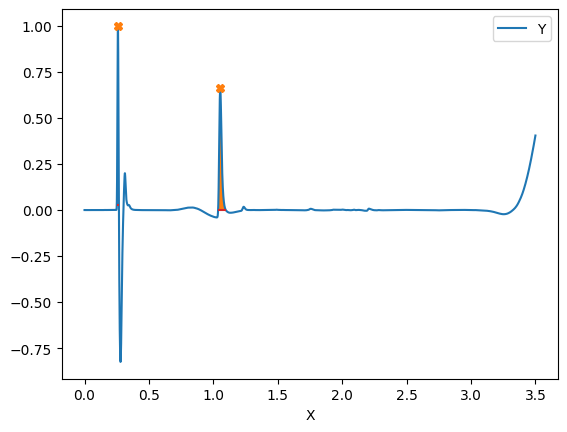

Scan Number: 33


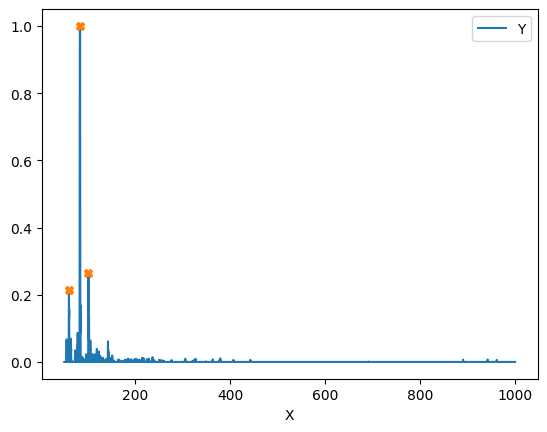

63      59.906666
267     83.010239
436    101.050720
Name: X, dtype: float64
--------------------------------------
Scan Number: 135


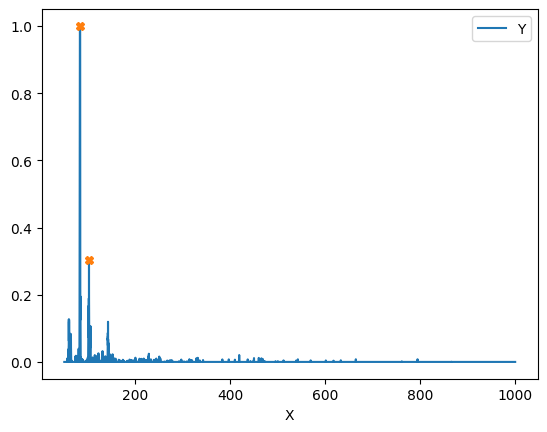

190     83.010239
385    102.126831
Name: X, dtype: float64
--------------------------------------
4cz d.raw
Peak Number: 1 Peak RT:  1.8949999809265137 Peak Area: 38.86810431420974 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  100.0 %


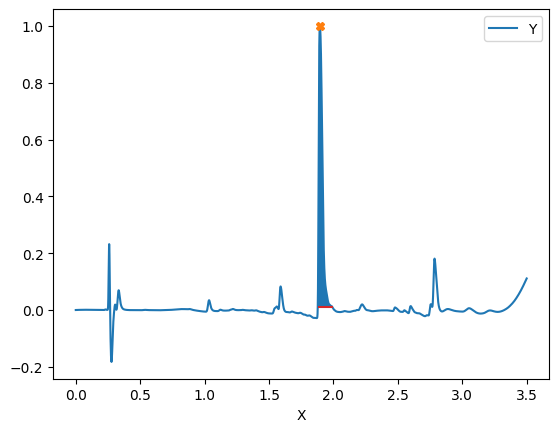

Scan Number: 242


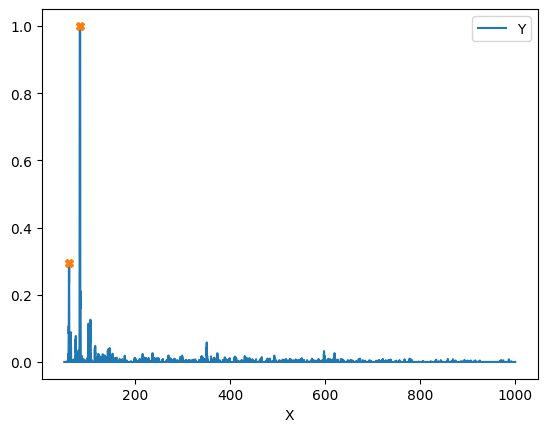

33     59.969967
223    83.010239
Name: X, dtype: float64
--------------------------------------
4cz n.raw
Peak Number: 1 Peak RT:  1.8966666460037231 Peak Area: 37.00682109918879 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  100.0 %


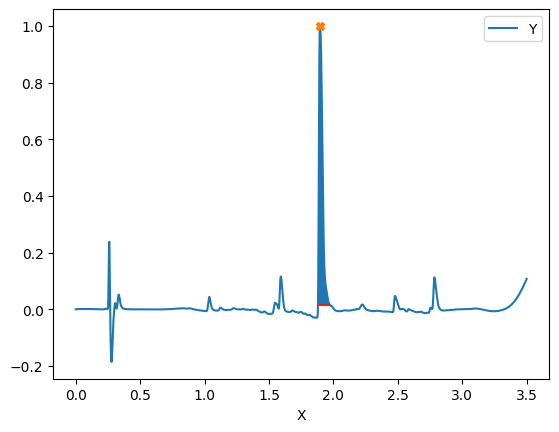

Scan Number: 242


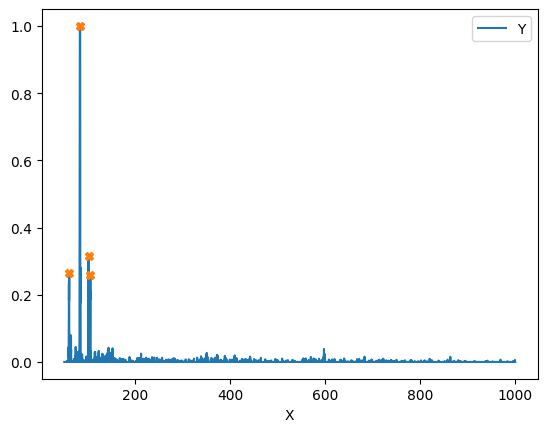

43      60.349735
243     83.010239
460    101.114021
518    105.038696
Name: X, dtype: float64
--------------------------------------
4cz s.raw
Peak Number: 1 Peak RT:  1.8949999809265137 Peak Area: 38.00683611247435 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  100.0 %


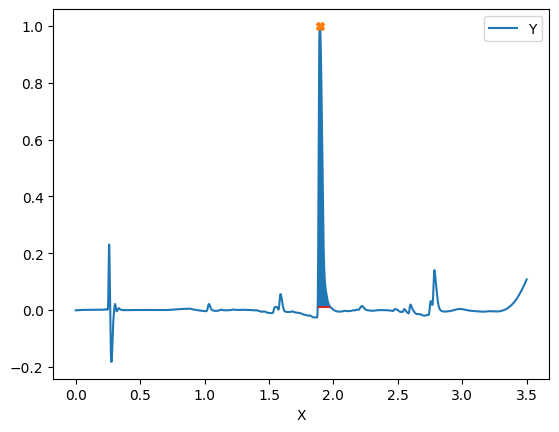

Scan Number: 242


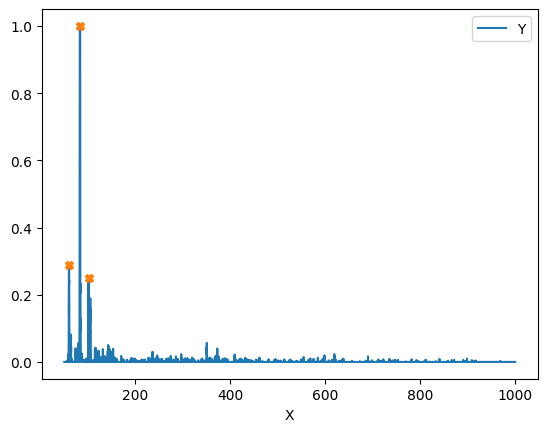

46      60.159851
233     83.010239
425    101.114021
Name: X, dtype: float64
--------------------------------------
benzyl acr dmf.raw
Peak Number: 1 Peak RT:  0.31833332777023315 Peak Area: 71.66833786570804 Peak Height:  0.49462934873919046
Peak Number: 2 Peak RT:  1.872499942779541 Peak Area: 55.98387104378734 Peak Height:  0.976922519918345
Peak Number: 3 Peak RT:  2.2191667556762695 Peak Area: 43.32416014568664 Peak Height:  1.0
Peak Number: 4 Peak RT:  2.4158332347869873 Peak Area: 35.53251427298065 Peak Height:  0.8267214637230381
Peak Number: 5 Peak RT:  2.5466666221618652 Peak Area: 15.497677665056123 Peak Height:  0.39539135701373096
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  32.28 %
Peak Number:  2 LC Area Percentage:  25.22 %
Peak Number:  3 LC Area Percentage:  19.51 %
Peak Number:  4 LC Area Percentage:  16.01 %
Peak Number:  5 LC Area Percentage:  6.98 %


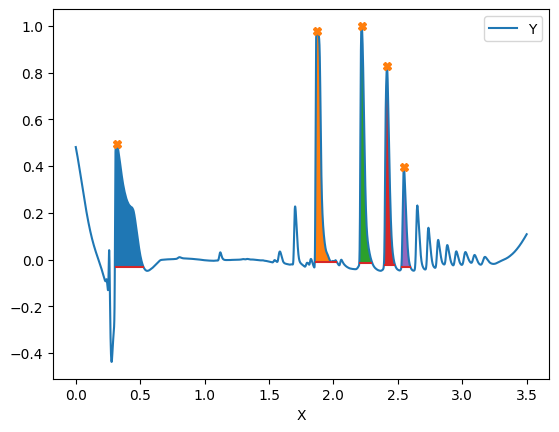

Scan Number: 41


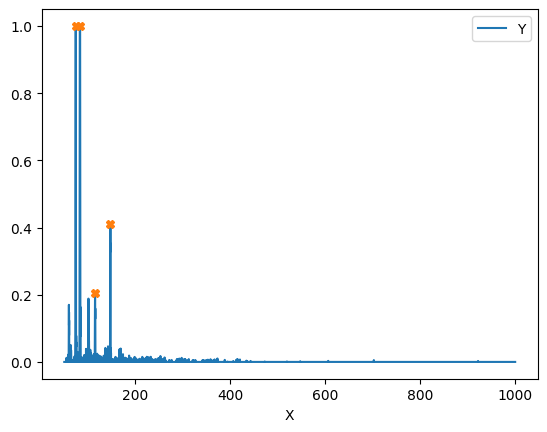

173     74.085167
301     83.010239
651    114.850510
958    147.135757
Name: X, dtype: float64
--------------------------------------
Scan Number: 239


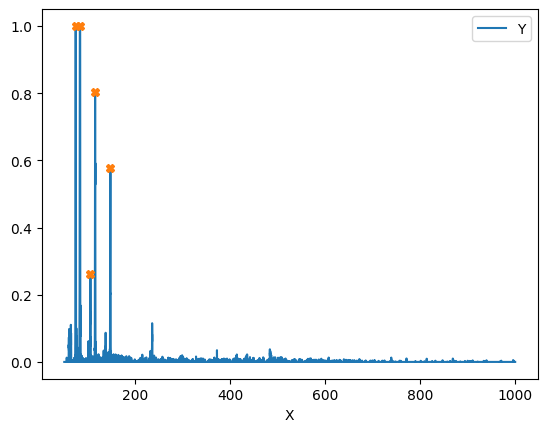

159     74.085167
276     83.010239
526    105.101997
599    115.040405
930    147.199051
Name: X, dtype: float64
--------------------------------------
Scan Number: 283


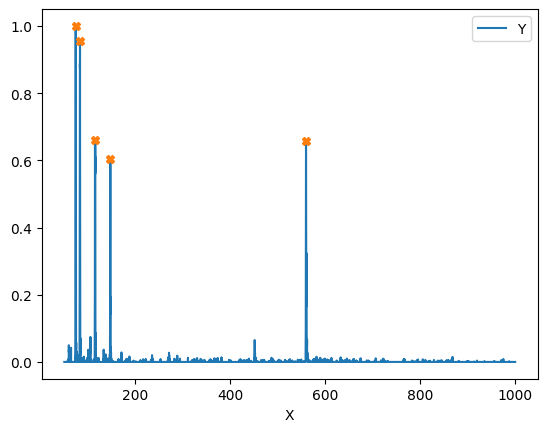

100      74.085167
197      83.200134
404     115.230316
592     147.072433
1383    559.320496
Name: X, dtype: float64
--------------------------------------
Scan Number: 309


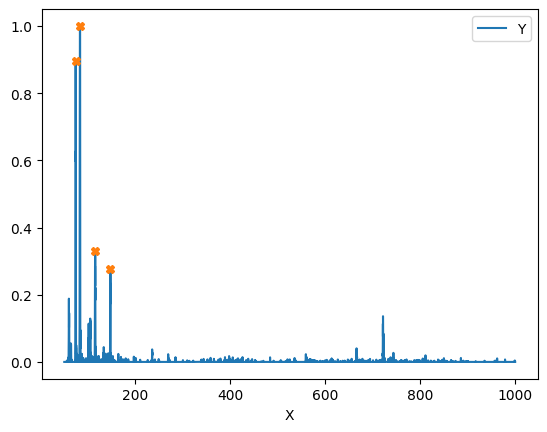

128     74.021881
237     83.136841
488    115.230316
743    147.262375
Name: X, dtype: float64
--------------------------------------
Scan Number: 325


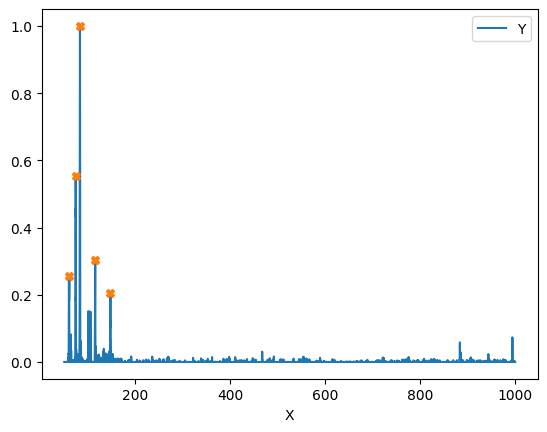

28      60.096554
130     74.021881
220     83.073540
434    115.293617
656    147.262375
Name: X, dtype: float64
--------------------------------------
benzyl acr mecn.raw
Peak Number: 1 Peak RT:  0.2591666579246521 Peak Area: 6.393667290176658 Peak Height:  0.6308768244203705
Peak Number: 2 Peak RT:  1.8766666650772095 Peak Area: 42.2026928538857 Peak Height:  0.8186466296728815
Peak Number: 3 Peak RT:  2.4183332920074463 Peak Area: 38.74037738602316 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  7.32 %
Peak Number:  2 LC Area Percentage:  48.32 %
Peak Number:  3 LC Area Percentage:  44.36 %


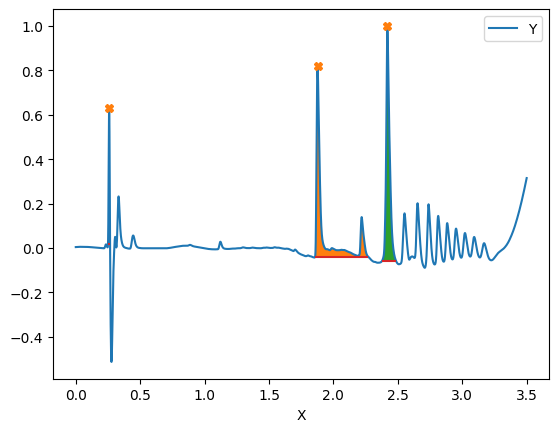

Scan Number: 33


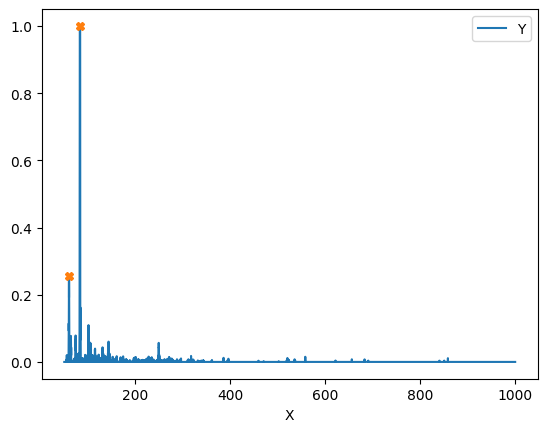

53     59.906666
279    83.010239
Name: X, dtype: float64
--------------------------------------
Scan Number: 240


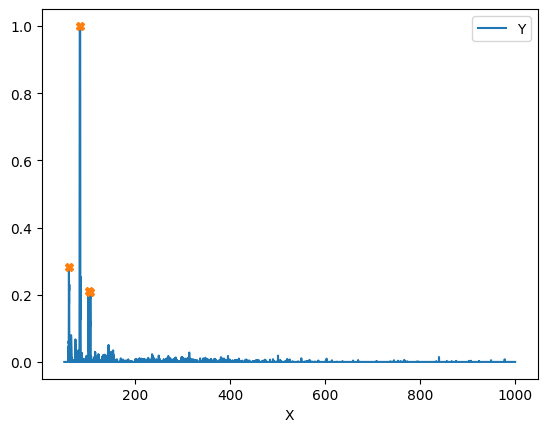

26      59.843369
219     83.010239
422    101.114021
479    104.785477
Name: X, dtype: float64
--------------------------------------
Scan Number: 309


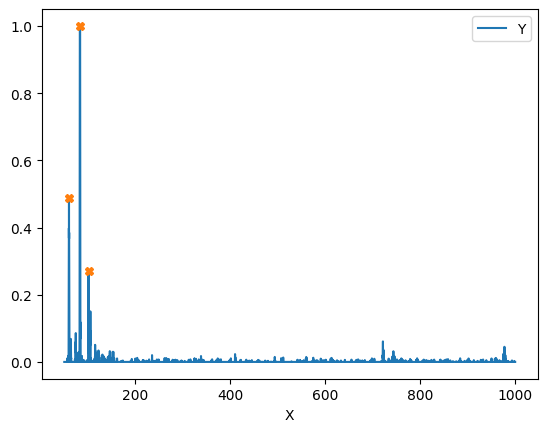

34      59.969967
207     83.010239
328    101.114021
Name: X, dtype: float64
--------------------------------------
17 n 2.raw
Peak Number: 1 Peak RT:  0.3216666579246521 Peak Area: 64.65513347711831 Peak Height:  0.4353010962869338
Peak Number: 2 Peak RT:  1.9924999475479126 Peak Area: 64.3229970627797 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  50.13 %
Peak Number:  2 LC Area Percentage:  49.87 %


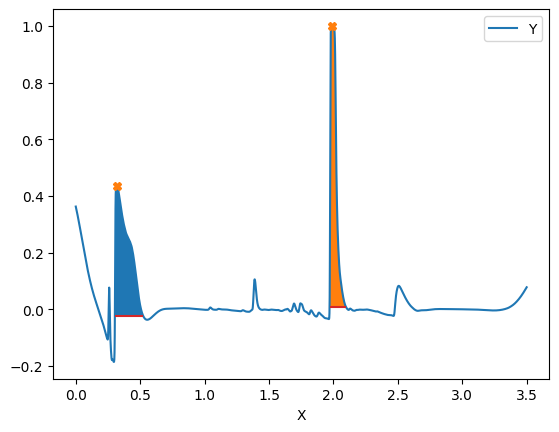

Scan Number: 41


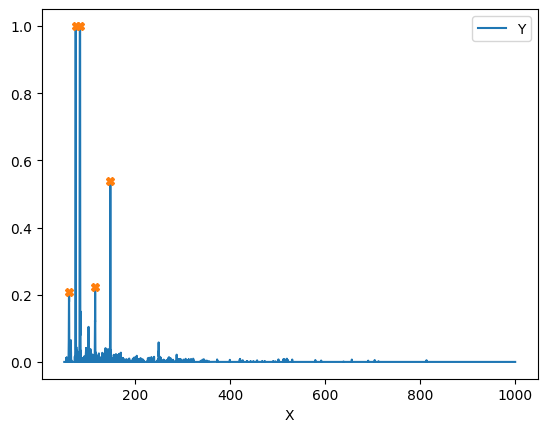

58      59.969967
155     74.211769
277     83.010239
602    115.103706
931    147.009155
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


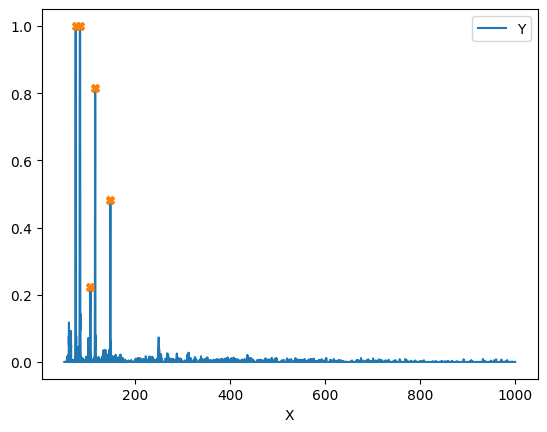

147     74.021881
267     83.010239
526    105.165283
600    115.167015
894    147.135757
Name: X, dtype: float64
--------------------------------------
17 s 2.raw
Peak Number: 1 Peak RT:  0.3216666579246521 Peak Area: 65.02060501517269 Peak Height:  0.4405696789016374
Peak Number: 2 Peak RT:  1.9924999475479126 Peak Area: 67.9083917391513 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  48.91 %
Peak Number:  2 LC Area Percentage:  51.09 %


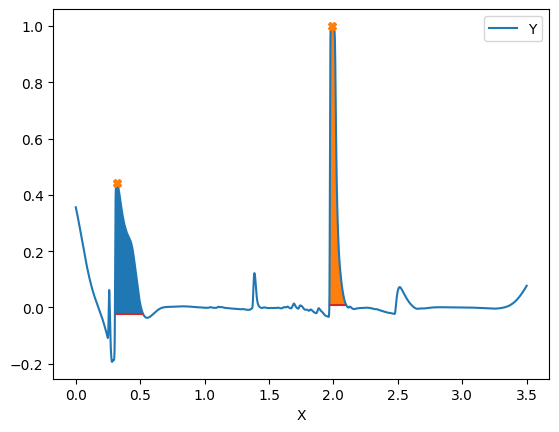

Scan Number: 41


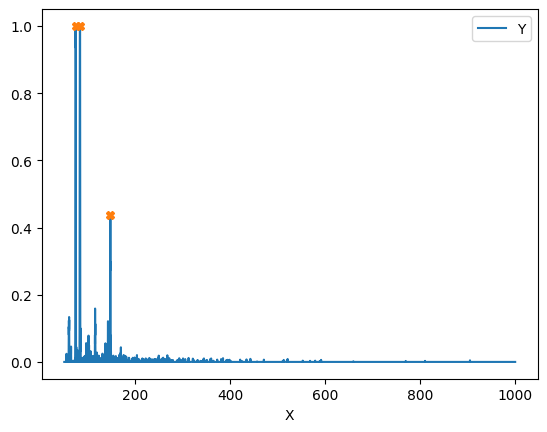

136     74.148468
257     83.010239
883    147.135757
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


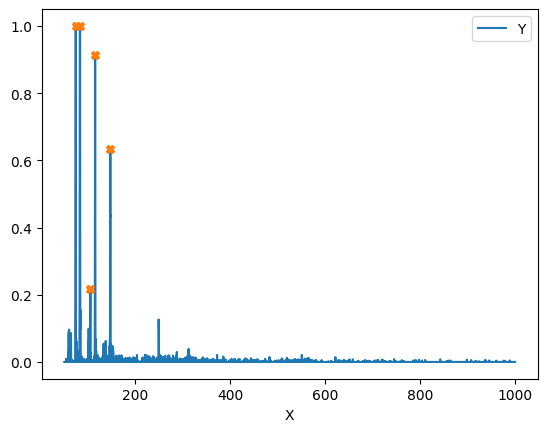

135     74.085167
250     83.010239
497    105.101997
570    115.103706
902    147.072433
Name: X, dtype: float64
--------------------------------------
17 d 2.raw
Peak Number: 1 Peak RT:  0.3191666603088379 Peak Area: 61.65333199510443 Peak Height:  0.41483689600106666
Peak Number: 2 Peak RT:  1.9883333444595337 Peak Area: 51.194918909710076 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  54.63 %
Peak Number:  2 LC Area Percentage:  45.37 %


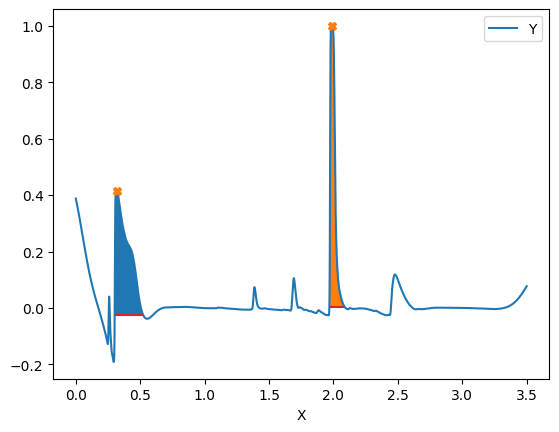

Scan Number: 41


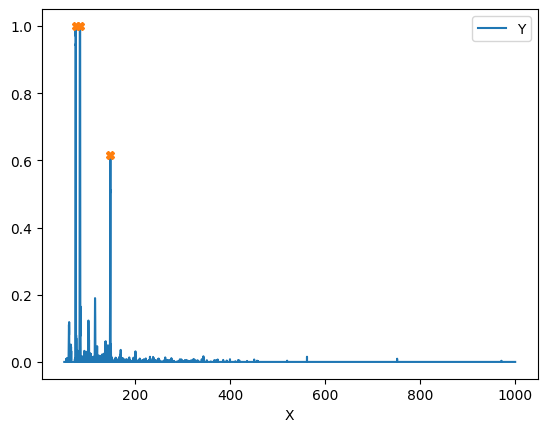

137     74.338364
251     83.073540
895    147.199051
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


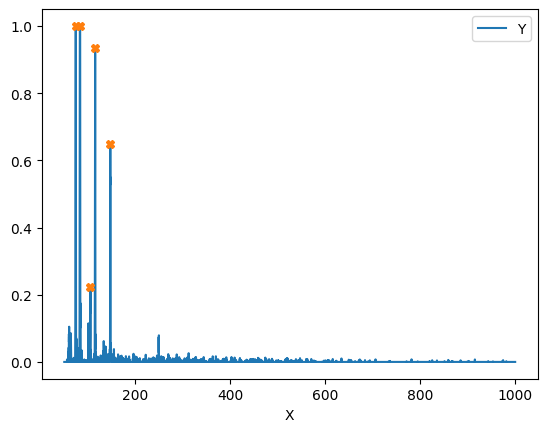

139     74.021881
266     83.010239
508    104.785477
586    115.167015
929    147.009155
Name: X, dtype: float64
--------------------------------------
16 n 2.raw
Peak Number: 1 Peak RT:  0.3216666579246521 Peak Area: 146.41977003996652 Peak Height:  1.0
Peak Number: 2 Peak RT:  2.0350000858306885 Peak Area: 56.52599011836548 Peak Height:  0.9833460648804838
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  72.15 %
Peak Number:  2 LC Area Percentage:  27.85 %


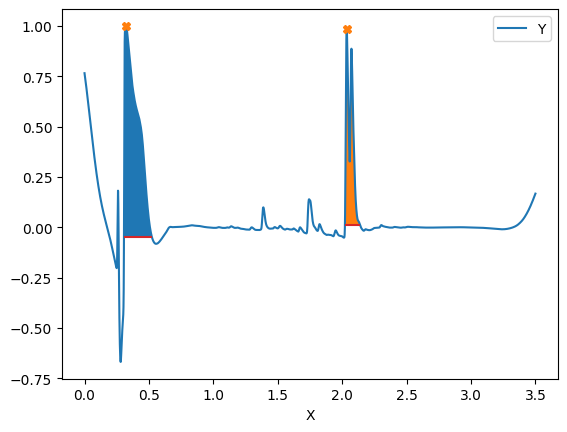

Scan Number: 41


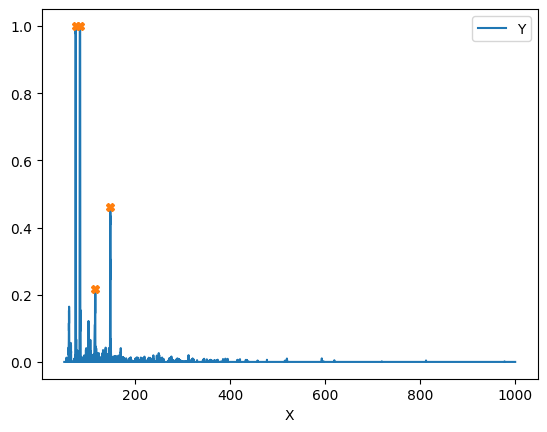

177     74.148468
303     83.010239
620    114.913811
978    147.072433
Name: X, dtype: float64
--------------------------------------
Scan Number: 260


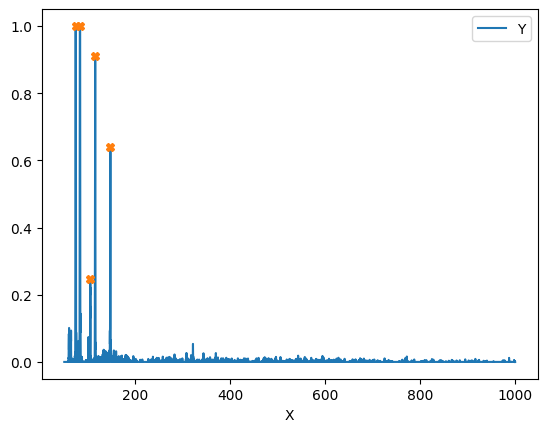

135     74.021881
259     83.010239
482    104.848785
558    115.230316
853    147.199051
Name: X, dtype: float64
--------------------------------------
16 s 2.raw
Peak Number: 1 Peak RT:  0.3199999928474426 Peak Area: 66.27724211738078 Peak Height:  0.45340638069698547
Peak Number: 2 Peak RT:  1.9916666746139526 Peak Area: 67.0539206245259 Peak Height:  1.0
Peak Number: 3 Peak RT:  2.0358333587646484 Peak Area: 1.3429139183140133 Peak Height:  0.38081792240693907
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  49.21 %
Peak Number:  2 LC Area Percentage:  49.79 %
Peak Number:  3 LC Area Percentage:  1.0 %


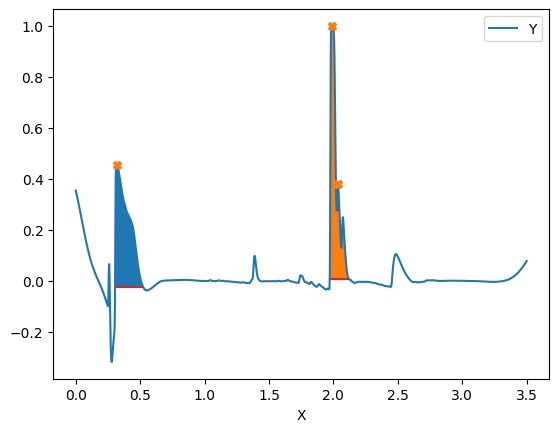

Scan Number: 41


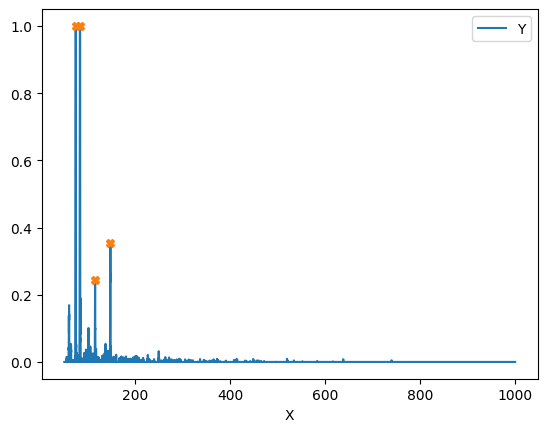

144     74.021881
266     83.010239
617    115.040405
953    147.199051
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


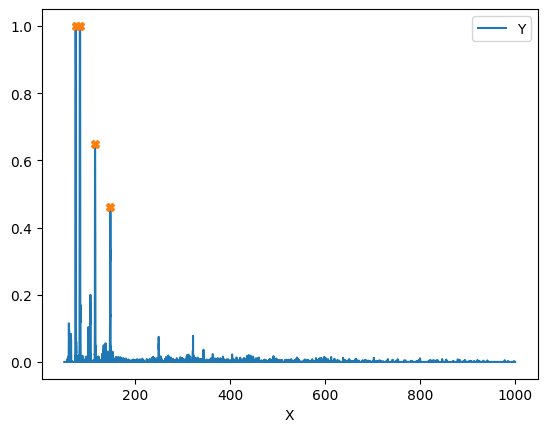

117     74.275063
221     83.010239
519    114.850510
829    147.072433
Name: X, dtype: float64
--------------------------------------
Scan Number: 260


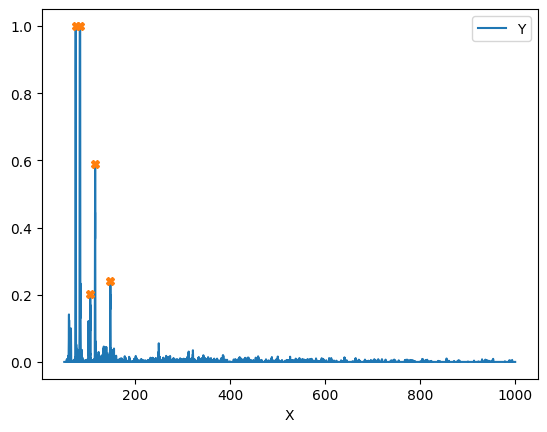

147     74.085167
253     83.010239
500    104.785477
570    115.103706
890    147.135757
Name: X, dtype: float64
--------------------------------------
16 d 2.raw
Peak Number: 1 Peak RT:  0.3199999928474426 Peak Area: 63.29406243862494 Peak Height:  0.4362864179788617
Peak Number: 2 Peak RT:  1.9924999475479126 Peak Area: 74.70713804739418 Peak Height:  1.0
Peak Number: 3 Peak RT:  2.0341665744781494 Peak Area: 0.5283024757139667 Peak Height:  0.44379842536597897
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  45.69 %
Peak Number:  2 LC Area Percentage:  53.93 %
Peak Number:  3 LC Area Percentage:  0.38 %


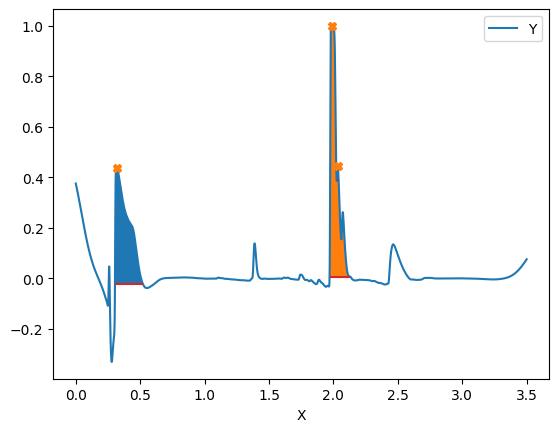

Scan Number: 41


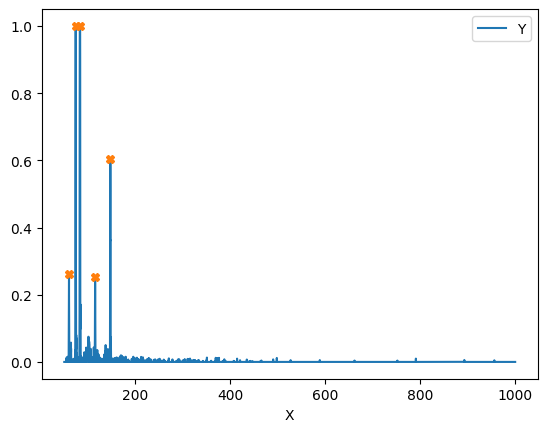

61      60.033264
174     74.021881
309     83.010239
674    115.040405
986    147.072433
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


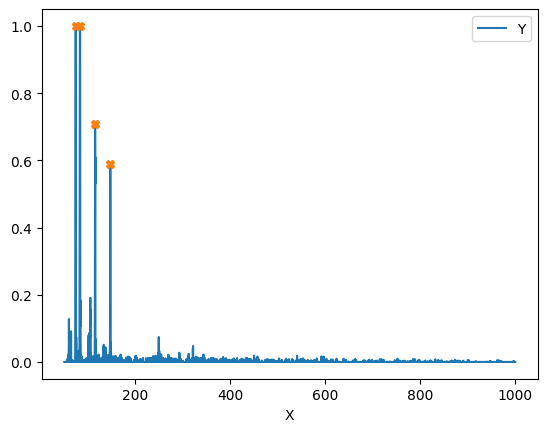

138     74.021881
255     83.010239
577    115.040405
893    147.009155
Name: X, dtype: float64
--------------------------------------
Scan Number: 260


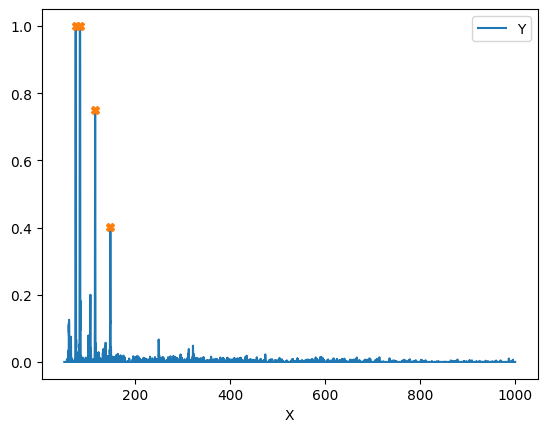

153     74.085167
266     83.010239
578    115.103706
895    147.199051
Name: X, dtype: float64
--------------------------------------
15 n 2.raw
Peak Number: 1 Peak RT:  0.32249999046325684 Peak Area: 76.14948322171546 Peak Height:  0.5237668607151363
Peak Number: 2 Peak RT:  1.940833330154419 Peak Area: 9.851547980838943 Peak Height:  0.28220745009619697
Peak Number: 3 Peak RT:  2.2808332443237305 Peak Area: 66.16287886337443 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  50.04 %
Peak Number:  2 LC Area Percentage:  6.47 %
Peak Number:  3 LC Area Percentage:  43.48 %


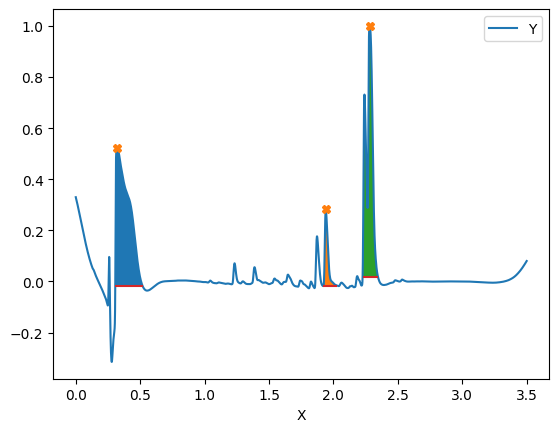

Scan Number: 41


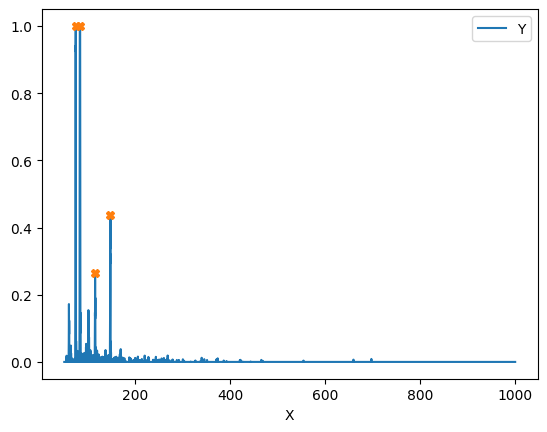

149     74.085167
272     83.010239
615    114.977097
940    147.009155
Name: X, dtype: float64
--------------------------------------
Scan Number: 248


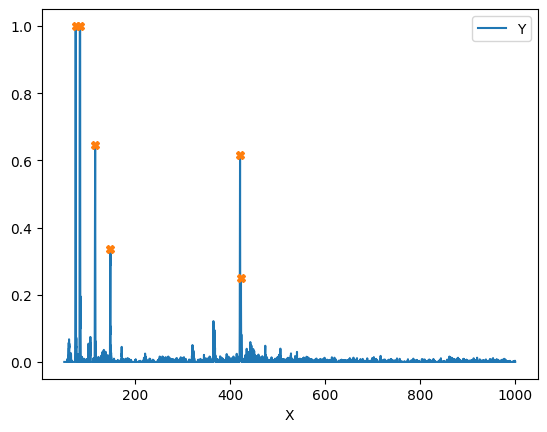

129      74.085167
240      83.010239
550     115.103706
809     147.009155
2208    420.360291
2239    422.323608
Name: X, dtype: float64
--------------------------------------
Scan Number: 291


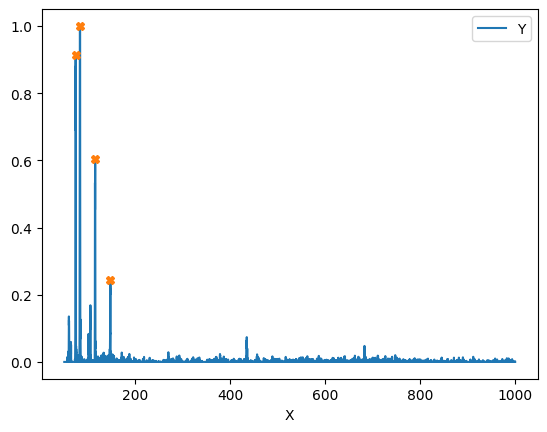

128     73.895287
233     83.073540
500    115.167015
780    147.262375
Name: X, dtype: float64
--------------------------------------
15 s 2.raw
Peak Number: 1 Peak RT:  0.3216666579246521 Peak Area: 73.22630462617491 Peak Height:  0.5019610156841493
Peak Number: 2 Peak RT:  2.2783334255218506 Peak Area: 66.51051062138802 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  52.4 %
Peak Number:  2 LC Area Percentage:  47.6 %


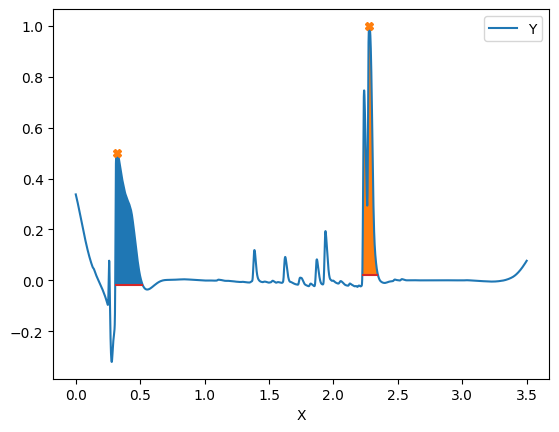

Scan Number: 41


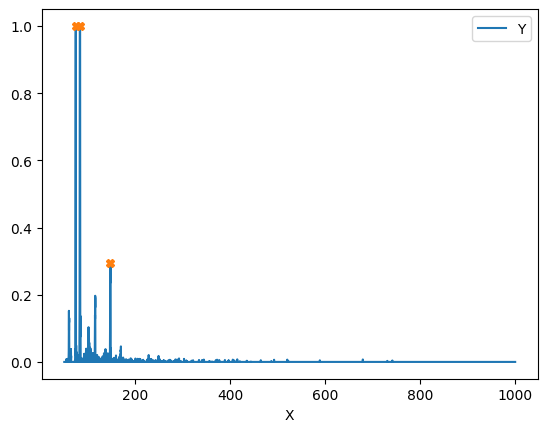

142     74.275063
251     83.010239
878    146.882538
Name: X, dtype: float64
--------------------------------------
Scan Number: 291


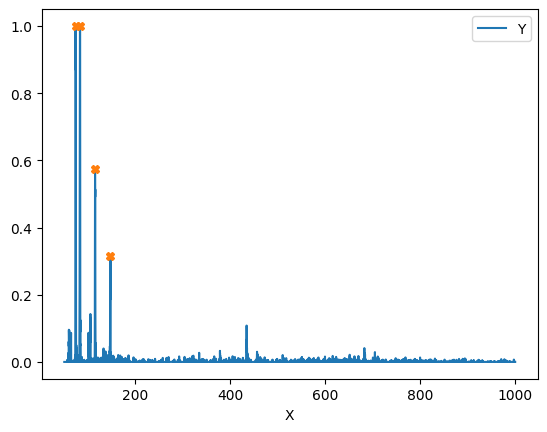

143     74.211769
247     83.010239
524    114.913811
805    147.009155
Name: X, dtype: float64
--------------------------------------
15 d 2.raw
Peak Number: 1 Peak RT:  0.3216666579246521 Peak Area: 75.27972508155673 Peak Height:  0.5155922750683
Peak Number: 2 Peak RT:  1.9383333921432495 Peak Area: 20.832825099409572 Peak Height:  0.6428443532465302
Peak Number: 3 Peak RT:  2.2783334255218506 Peak Area: 56.944378009770546 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  49.18 %
Peak Number:  2 LC Area Percentage:  13.61 %
Peak Number:  3 LC Area Percentage:  37.2 %


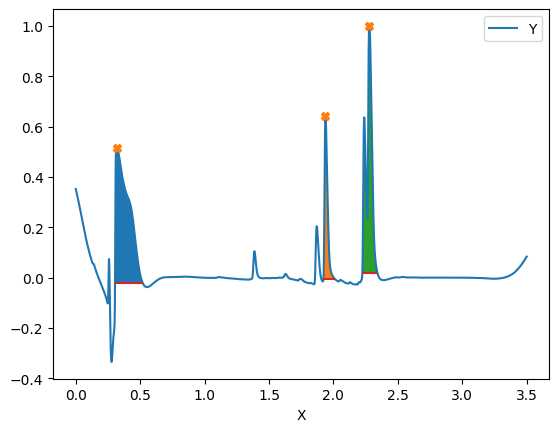

Scan Number: 41


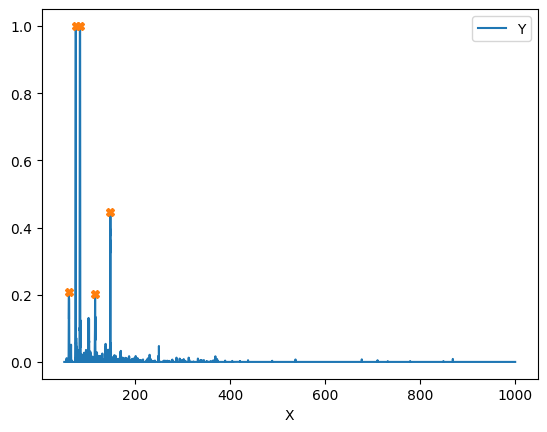

56      59.843369
159     74.211769
283     83.010239
658    114.977097
968    147.199051
Name: X, dtype: float64
--------------------------------------
Scan Number: 248


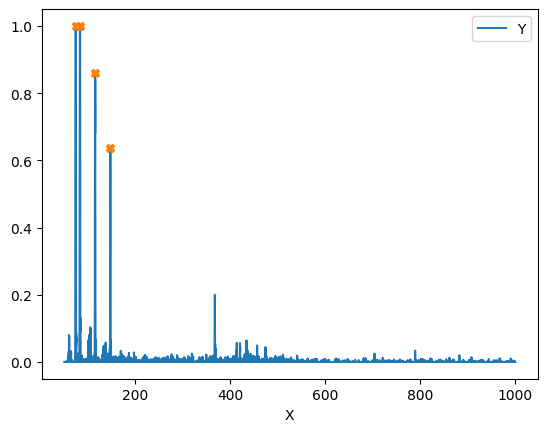

142     74.021881
256     83.010239
573    114.850510
904    147.072433
Name: X, dtype: float64
--------------------------------------
Scan Number: 291


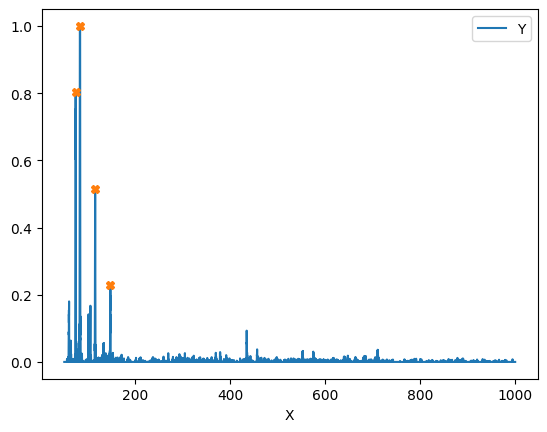

146     74.021881
255     83.010239
507    115.103706
824    147.135757
Name: X, dtype: float64
--------------------------------------
14 n 2.raw
Peak Number: 1 Peak RT:  0.3233333230018616 Peak Area: 69.64907144862161 Peak Height:  0.4744907519180024
Peak Number: 2 Peak RT:  1.9874999523162842 Peak Area: 42.57179103111294 Peak Height:  1.0
Peak Number: 3 Peak RT:  2.2166666984558105 Peak Area: 39.275782055941505 Peak Height:  0.6353165177478476
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  45.97 %
Peak Number:  2 LC Area Percentage:  28.1 %
Peak Number:  3 LC Area Percentage:  25.93 %


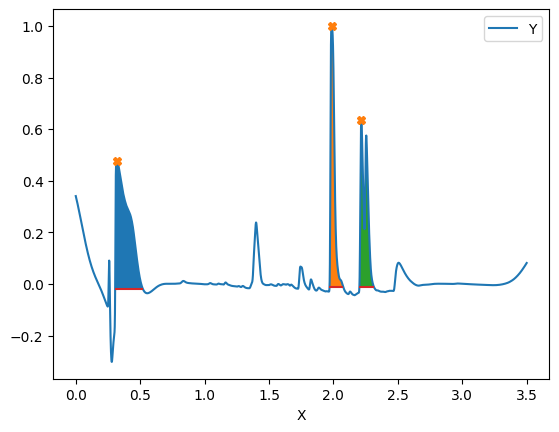

Scan Number: 41


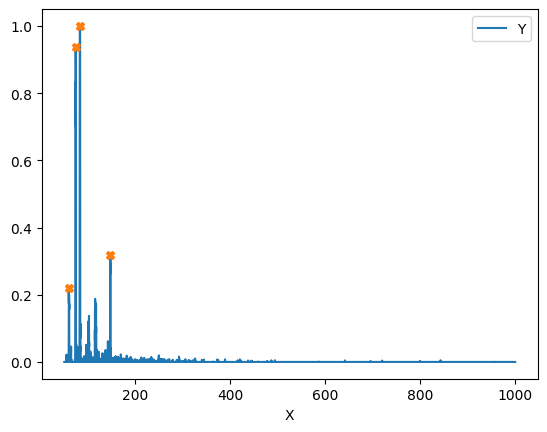

66      59.843369
163     74.021881
274     82.946938
914    147.199051
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


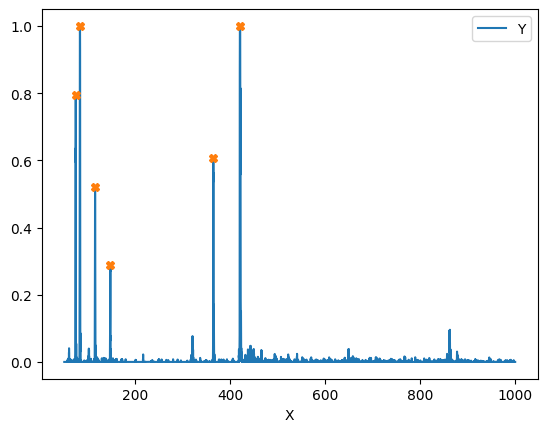

99       74.211769
184      83.326721
349     114.913811
488     147.009155
880     364.060486
1058    420.233673
Name: X, dtype: float64
--------------------------------------
Scan Number: 283


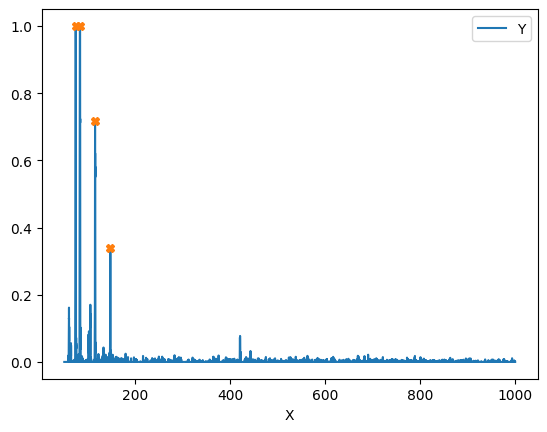

130     74.148468
227     83.010239
505    114.913811
783    147.072433
Name: X, dtype: float64
--------------------------------------
14 s 2.raw
Peak Number: 1 Peak RT:  0.32249999046325684 Peak Area: 74.60651440245904 Peak Height:  0.5084172464769456
Peak Number: 2 Peak RT:  1.9866666793823242 Peak Area: 35.9607704474225 Peak Height:  1.0
Peak Number: 3 Peak RT:  2.2166666984558105 Peak Area: 65.35373817380086 Peak Height:  0.9283257540553259
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  42.41 %
Peak Number:  2 LC Area Percentage:  20.44 %
Peak Number:  3 LC Area Percentage:  37.15 %


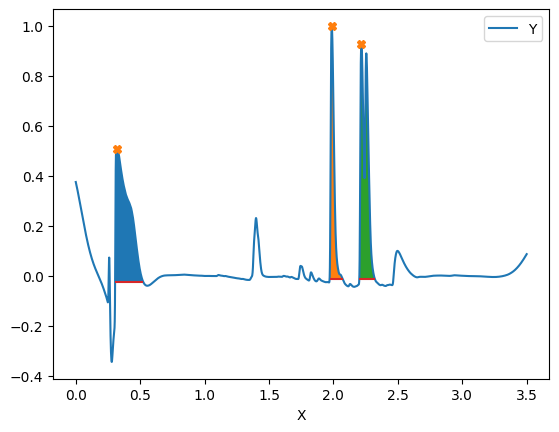

Scan Number: 41


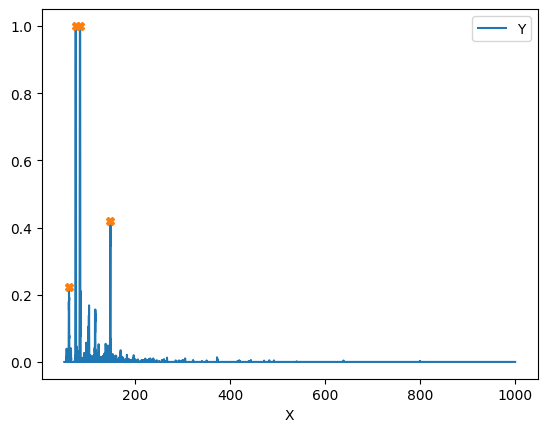

47      59.969967
129     74.085167
256     83.010239
938    147.325668
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


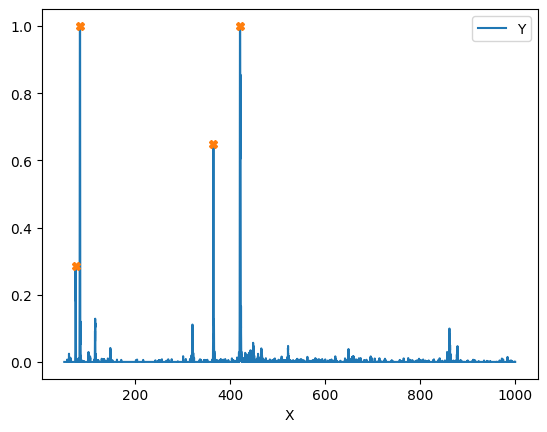

67      74.275063
131     83.073540
699    364.250458
881    420.233673
Name: X, dtype: float64
--------------------------------------
Scan Number: 283


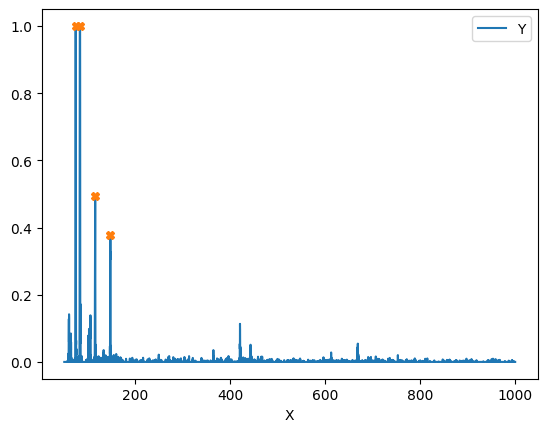

136     74.085167
241     83.010239
515    115.167015
784    147.135757
Name: X, dtype: float64
--------------------------------------
14 d 2.raw
Peak Number: 1 Peak RT:  0.32083332538604736 Peak Area: 73.74274260729956 Peak Height:  0.5049665444632744
Peak Number: 2 Peak RT:  2.2149999141693115 Peak Area: 74.55758535016437 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  49.73 %
Peak Number:  2 LC Area Percentage:  50.27 %


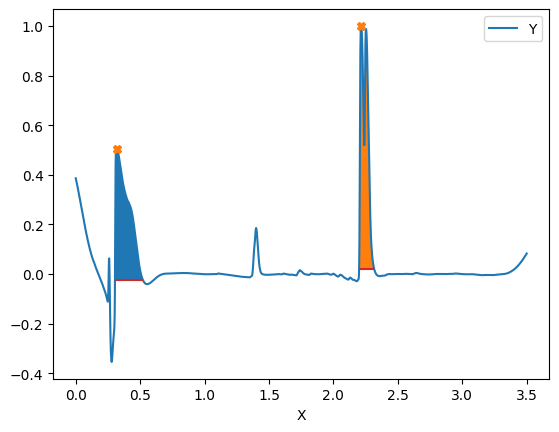

Scan Number: 41


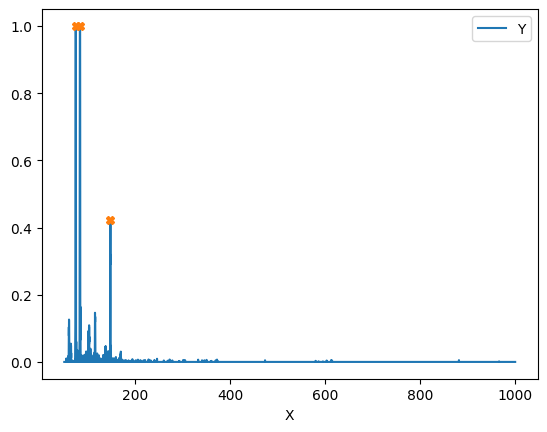

142     74.021881
266     83.010239
907    147.262375
Name: X, dtype: float64
--------------------------------------
Scan Number: 283


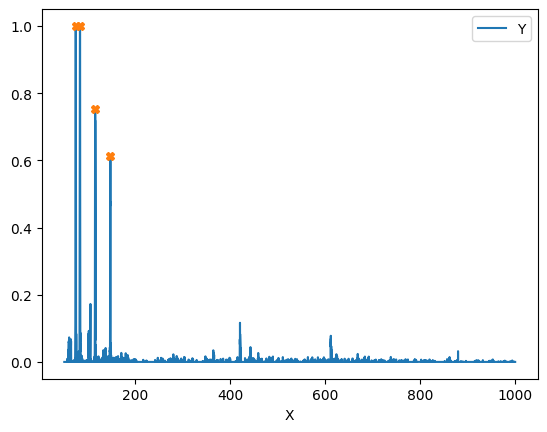

153     74.021881
267     83.010239
526    115.167015
786    147.199051
Name: X, dtype: float64
--------------------------------------
Acr 3 2.raw
Peak Number: 1 Peak RT:  1.5199999809265137 Peak Area: 42.2495774536156 Peak Height:  0.2933511862392155
Peak Number: 2 Peak RT:  1.8958333730697632 Peak Area: 37.295287431432186 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  53.11 %
Peak Number:  2 LC Area Percentage:  46.89 %


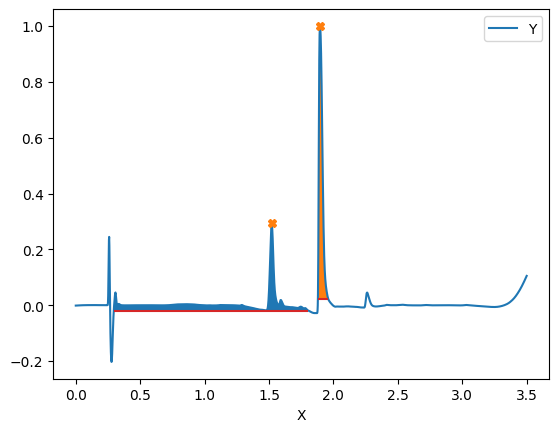

Scan Number: 194


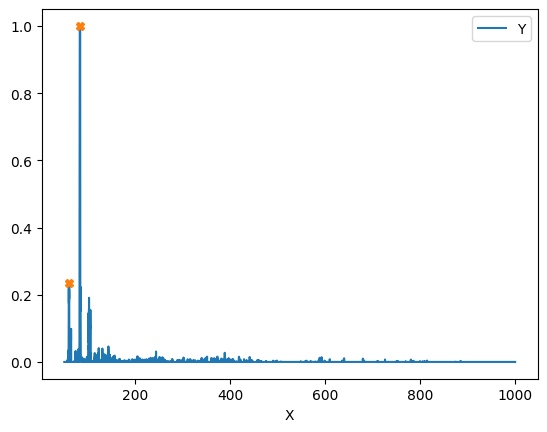

46     60.349735
228    83.010239
Name: X, dtype: float64
--------------------------------------
Scan Number: 242


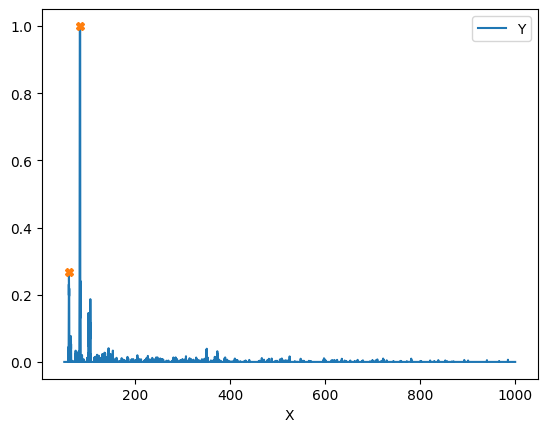

26     59.843369
197    83.073540
Name: X, dtype: float64
--------------------------------------
Acr x 2.raw
Peak Number: 1 Peak RT:  0.25833332538604736 Peak Area: 7.082968577789327 Peak Height:  0.693533818448017
Peak Number: 2 Peak RT:  1.034166693687439 Peak Area: 63.70236692310002 Peak Height:  0.5087364599426847
Peak Number: 3 Peak RT:  1.5225000381469727 Peak Area: 38.38313839256349 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  6.49 %
Peak Number:  2 LC Area Percentage:  58.35 %
Peak Number:  3 LC Area Percentage:  35.16 %


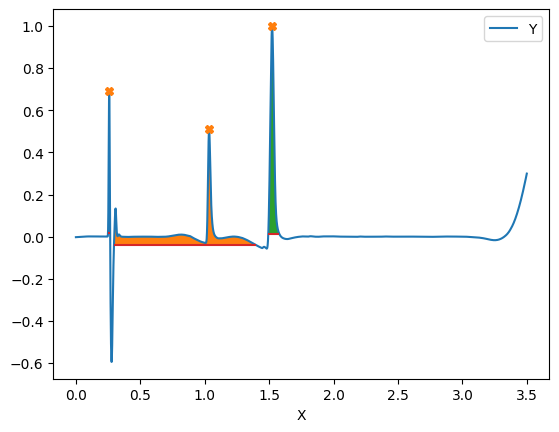

Scan Number: 33


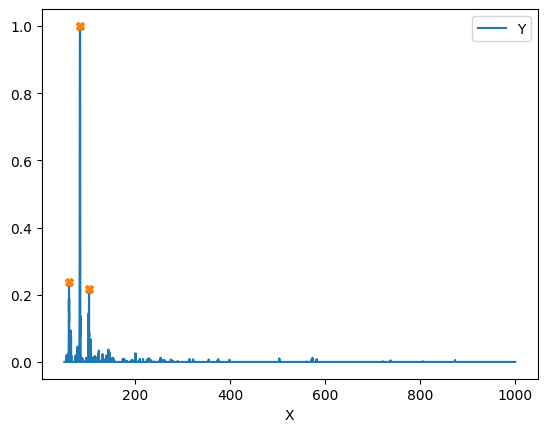

62      60.033264
243     83.010239
429    102.380028
Name: X, dtype: float64
--------------------------------------
Scan Number: 132


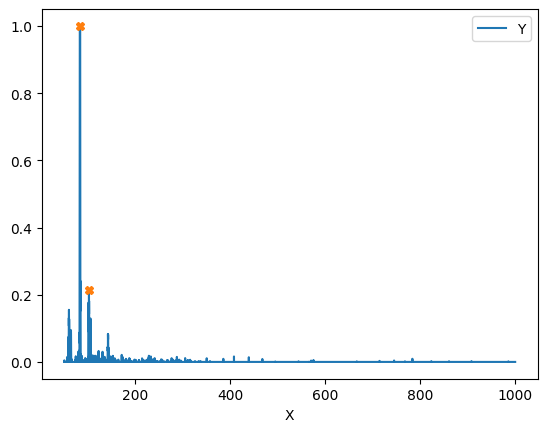

217     83.010239
456    102.063530
Name: X, dtype: float64
--------------------------------------
Scan Number: 194


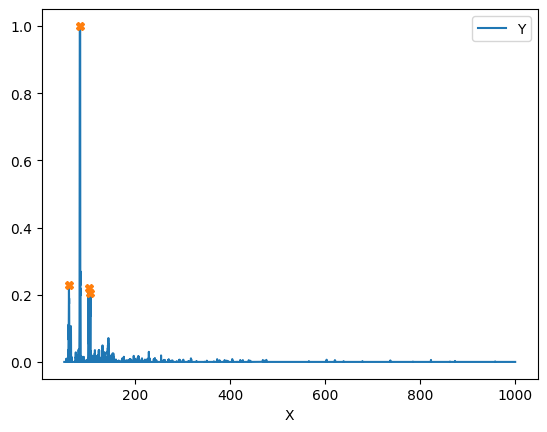

44      59.906666
227     83.010239
479    102.063530
523    104.848785
Name: X, dtype: float64
--------------------------------------
Acr pr  2.raw
Peak Number: 1 Peak RT:  0.2591666579246521 Peak Area: 7.763476429414591 Peak Height:  0.769539806863074
Peak Number: 2 Peak RT:  1.5208333730697632 Peak Area: 34.97798834518068 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  18.16 %
Peak Number:  2 LC Area Percentage:  81.84 %


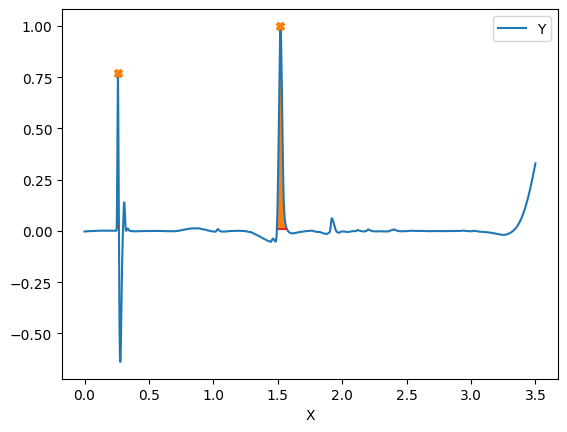

Scan Number: 33


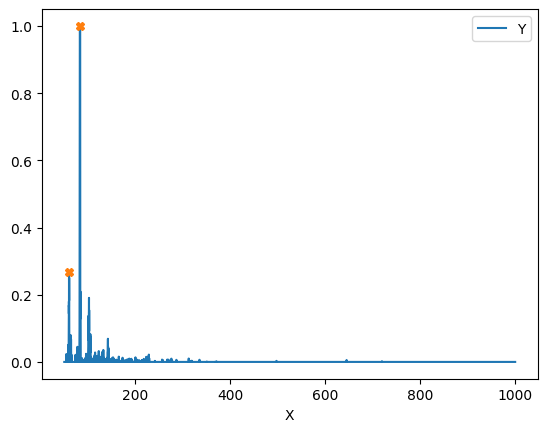

68     60.033264
263    83.010239
Name: X, dtype: float64
--------------------------------------
Scan Number: 194


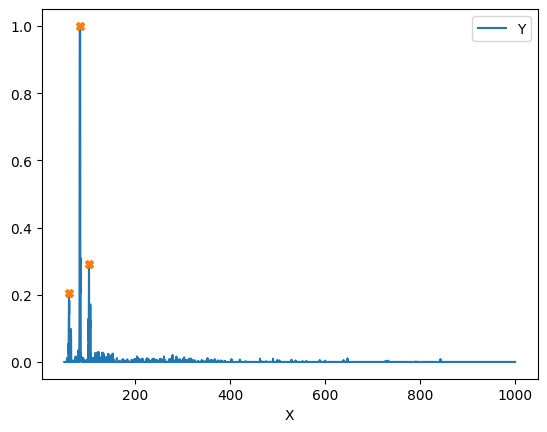

44      60.033264
225     83.010239
487    102.126831
Name: X, dtype: float64
--------------------------------------
Ir 2.raw
Peak Number: 1 Peak RT:  1.5191667079925537 Peak Area: 75.59932669318326 Peak Height:  0.25622743597161074
Peak Number: 2 Peak RT:  1.8933333158493042 Peak Area: 62.25655759126077 Peak Height:  1.0
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  54.84 %
Peak Number:  2 LC Area Percentage:  45.16 %


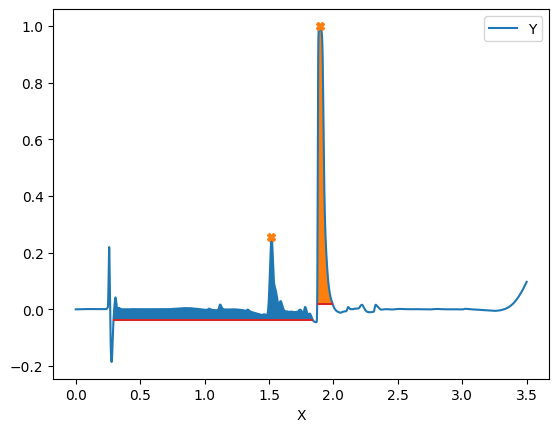

Scan Number: 194


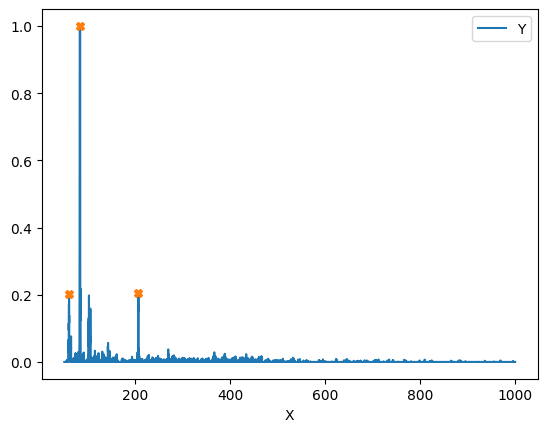

50       60.159851
232      83.010239
1102    206.266785
Name: X, dtype: float64
--------------------------------------
Scan Number: 242


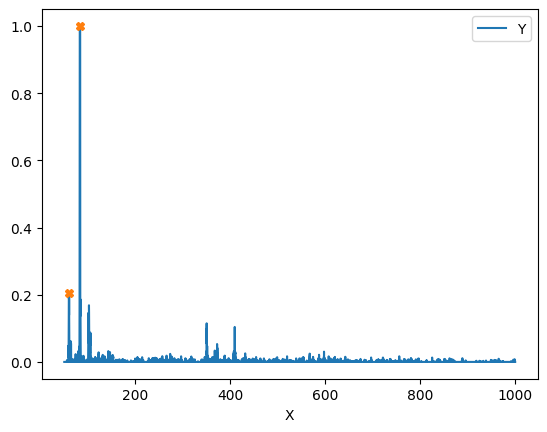

39     59.906666
230    83.010239
Name: X, dtype: float64
--------------------------------------
diethyl 2.raw
Peak Number: 1 Peak RT:  0.25833332538604736 Peak Area: 10.262162824380287 Peak Height:  1.0
Peak Number: 2 Peak RT:  1.9850000143051147 Peak Area: 19.400115536600293 Peak Height:  0.6629452343528123
-------------------------------------------------
Peak Number:  1 LC Area Percentage:  34.6 %
Peak Number:  2 LC Area Percentage:  65.4 %


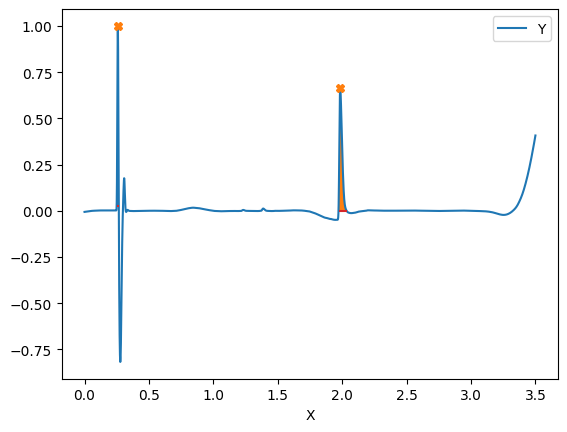

Scan Number: 33


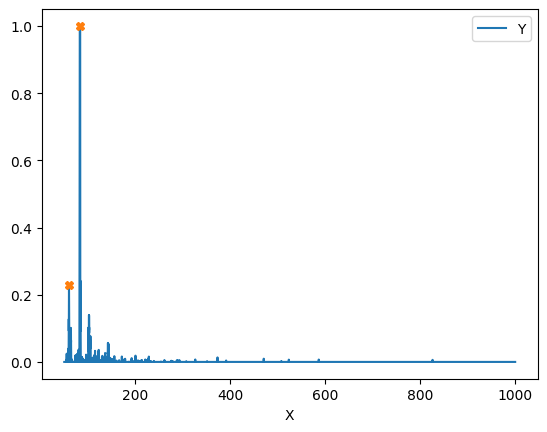

54     59.969967
283    83.010239
Name: X, dtype: float64
--------------------------------------
Scan Number: 254


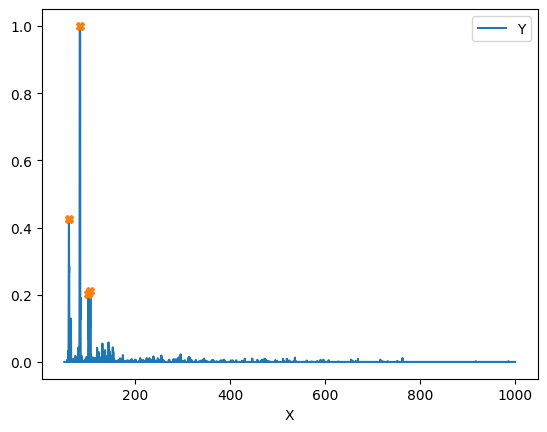

36      59.906666
205     83.010239
386    100.924110
451    105.165283
Name: X, dtype: float64
--------------------------------------


{}

In [21]:
#MSProcessFolder(MSDirectory, "ES+", MSJSonpredict)
#AnalogProcess(MSDirectory)
SynthProcess(MSDirectory)